In [1]:
import eigsep_observing as eo

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os
from datetime import datetime
%matplotlib widget

In [28]:
from eigsep_data import Imu
# import eigsep_data

ImportError: cannot import name 'Imu' from 'eigsep_data.imu' (/home/dominiv/eigsep/data-analysis/src/eigsep_data/imu.py)

## Note: before Friday night, the box antenna was in input 4 on the snap, afterwards it was in 2

Sunday observation, started at 9:58, found the time i replaced the rfsoc battery at 11:01, in notes its 12:01, so sweep should have ended around 12:12 if sleep between sweeps was 1 hour long. next sweep started at 1:12 in notes, pretty sure that was in PDT. The sweep pattern was Az rotates 50? deg, then El does a full back and forth sweep, then repeat. there were no stalls in this sweep

This type of sweep should take about 1 hour 14-15 minutes

In [3]:
path = '/home/dominiv/eigsep/data/july2025/corr_data/'
thursday = 'corr_20250717_*' # all data is in PDT, utah is 1 hour ahead of us
friday = 'corr_20250718_*'
files = glob.glob(path+friday)
print(len(files))

226


In [4]:
waveform = np.load('/home/dominiv/eigsep/data/july2025/trans_spec/transmitter.npz')
print(waveform.keys())
bram = waveform['max_addr']
waveform = waveform['data']
trans_spec = np.fft.fft(waveform)

# plt.figure()
# plt.plot(np.abs(trans_spec))
# plt.show()

KeysView(NpzFile '/home/dominiv/eigsep/data/july2025/trans_spec/transmitter.npz' with keys: data, max_addr)


In [5]:
def file_finder(path, date, start, end):
    files = glob.glob(path+'corr_'+date+'_*')
    start_time = datetime.strptime(date+f'_{start}', '%Y%m%d_%H%M%S')
    end_time = datetime.strptime(date+f'_{end}', '%Y%m%d_%H%M%S')
    filtered_files = []
    for file in files:
        basename = os.path.basename(file)
        try:
            timestamp_str = basename[5:-3]  # Strip 'corr_' prefix and '.h5' suffix
            file_time = datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")
            if start_time <= file_time <= end_time:
                filtered_files.append(file)
        except ValueError:
            continue
    ordered_files = sorted(filtered_files)
    print('Number of files:', len(ordered_files))
    print(f'{str(ordered_files[0])}, {str(ordered_files[-1])}')
    return ordered_files

def header_check(picos, idx, header='imu_panda'):
    if f'{header}' not in picos.keys():
        print(f'{header} not found in file:', idx)

def data_extract(files):
    data_list = []
    corr_list = []
    pico_list = []
    for i in range(len(files)):
        data, corr, pico = eo.io.read_hdf5(files[i])
        header_check(pico, i)
        data_list.append(data)
        corr_list.append(corr)
        pico_list.append(pico)
    return data_list, corr_list, pico_list

def spectra(data, ant, corr):
    data_stack = [d[ant] for d in data]
    data_stack = np.array(data_stack)
    data_stack = np.concatenate(data_stack, axis=0)

    times = [d['times'] for d in corr]
    times = np.array(times)
    times = np.concatenate(times, axis=0)
    return data_stack, times

def waterfall(data, times, freqs):
    dt = [datetime.fromtimestamp(ts) for ts in times]
    t_md = mdates.date2num(dt)
    plt.figure(figsize=(10,6))
    plt.imshow(np.log10(data), aspect = 'auto', interpolation='none', extent = [freqs[0], freqs[-1], t_md[-1], t_md[0]], 
               origin='upper', cmap='viridis')
    ax = plt.gca()
    ax.yaxis_date()
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Time of Day')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plotter(freqs, spec, amount=[0,0]):
    plt.figure(figsize=(10,6))
    if spec.shape[:][0] > 1 and amount != [0,0]:
        for i in range(amount[0], amount[1]):
            plt.semilogy(freqs, spec[i], label=f'Spectra index: {i}')
    else:
        plt.semilogy(freqs, spec, label='Spectra')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.show()



def pico_info(picos, device, info):
    pico = [d[device] for d in picos]
    print(len(pico))
    print(type(pico))
    print(type(pico[0]))
    pl   = [entry[info] 
            for sublist in pico 
            for entry   in sublist]
    print(type(pl), len(pl))
    return np.array(pl)


# test_finder = file_finder(path, '20250718', '121000', '122300') # First? Friday sweep, first few minutes something went wrong, actually started at 11:53
# test_finder = file_finder(path, '20250718', '133500', '152000') # Second? Friday sweep, IMU stuck reporting same number
# test_finder = file_finder(path, '20250718', '214500', '235500') # Over night sweep, snap dies at about 12:30, IMU still dead 
# test_finder = file_finder(path, '20250719', '124000', '144000') # First Recording after full lift on Saturday, IMU still dead 
# test_finder = file_finder(path, '20250717', '154000', '164000') # First Thursday sweep, best IMU data
# test_finder = file_finder(path, '20250718', '133000', '143000') 
test_finder = file_finder(path, '20250720', '095800', '121300') # sunday from 9:58 pdt, battery swap at around 11:01

# print(test_finder==filtered_files)

data_test, corr_test, pico_test = data_extract(test_finder)

data_stack, times = spectra(data_test, '2', corr_test)

# el_test = pico_info(pico_test, 'motor', 'el_pos')
accel_xtest = pico_info(pico_test, 'imu_panda', 'accel_x')

Number of files: 31
/home/dominiv/eigsep/data/july2025/corr_data/corr_20250720_095951.h5, /home/dominiv/eigsep/data/july2025/corr_data/corr_20250720_120851.h5
31
<class 'list'>
<class 'list'>
<class 'list'> 7430


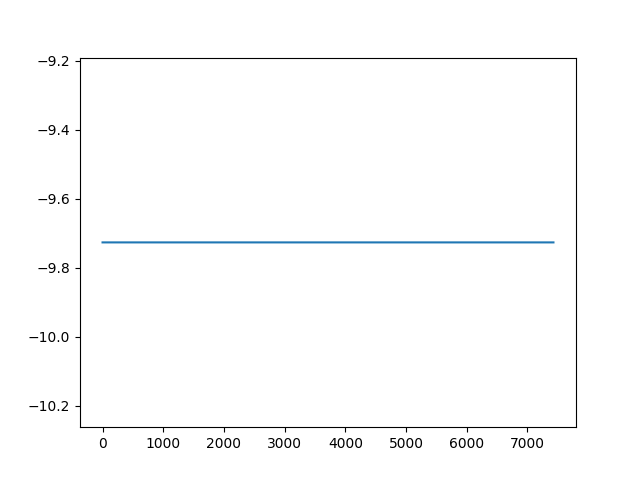

In [6]:
# print(pico_test[0].keys())
# print(pico_test[0]['temp_mon'][0])
# print(pico_test[0]['imu_panda'][0])
# print(pico_test[-1]['imu_panda'][0])
# print(pico_test[0]['imu_panda'] == pico_test[-5]['imu_panda'])

# accel_ytest = pico_info(pico_test, 'imu_panda', 'accel_y')
plt.figure()
plt.plot(accel_xtest)
plt.show()

In [25]:
plt.close('all')

/tmp/ipykernel_48029/155507093.py:50: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(data), aspect = 'auto', interpolation='none', extent = [freqs[0], freqs[-1], t_md[-1], t_md[0]],
/tmp/ipykernel_48029/155507093.py:50: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data), aspect = 'auto', interpolation='none', extent = [freqs[0], freqs[-1], t_md[-1], t_md[0]],


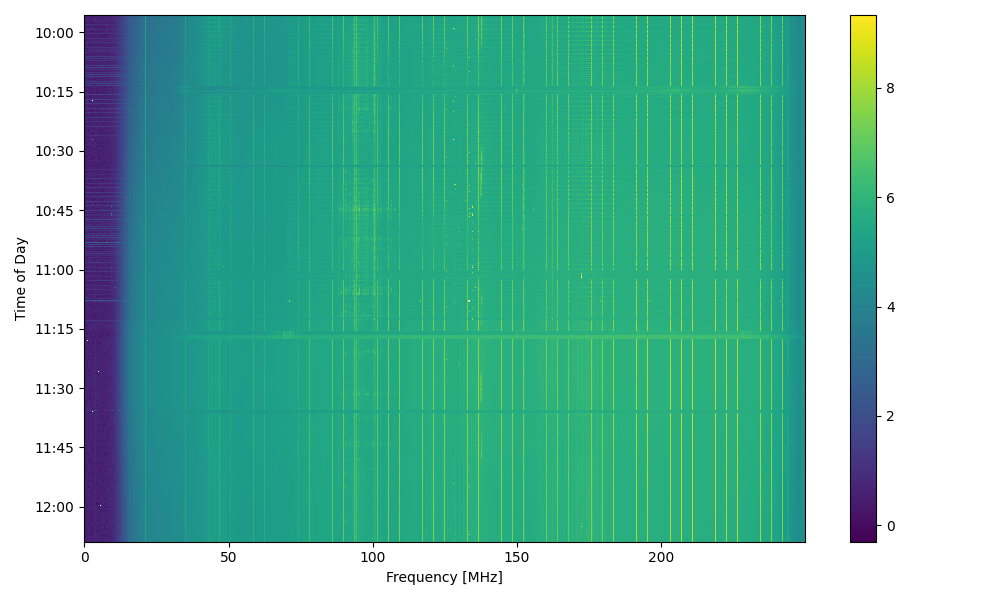

In [7]:
freqs = corr_test[0]['freqs']
waterfall(data_stack, times, freqs)

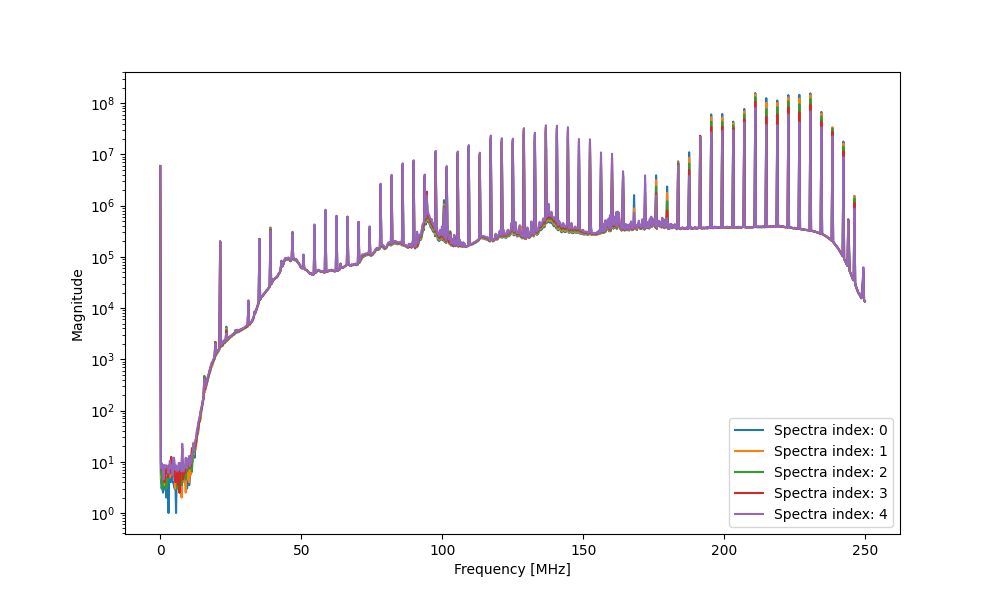

In [8]:
# obs = eo.io.read_hdf5('/home/dominiv/eigsep/data/july2025/corr_data/corr_20250718_100126.h5')
plotter(freqs, data_stack, amount=[0,5])
# plotter(freqs, data_stack[0])
# plotter(freqs, obs[0]['4'][0])

Found low level spikes in the rfsoc transmission at 0 MHz and past 250 MHz. all below 150 magnitude

In [12]:
def spike_extract(freqs, spec, rfsoc_wave, rfsoc_sample_rate=1000):
    rfsoc_fft = np.fft.fft(rfsoc_wave)
    _freqs = np.fft.fftfreq(len(rfsoc_fft), 1/rfsoc_sample_rate)
    mask = (_freqs >= 0) & (_freqs <= 250)
    rfsoc_idx = np.where(np.abs(rfsoc_fft)[mask] > 4e5)[0]
    expected_spikes = _freqs[rfsoc_idx]
    rounded_spikes = np.round(expected_spikes, 8)
    spike_mask = np.isin(freqs, rounded_spikes)
    spike_idx = np.nonzero(spike_mask)[0]
    freqs = np.array(freqs)
    freq_values = freqs[spike_idx]
    spike_values = np.log10(data_stack[:,spike_idx])
    return spike_idx, freq_values, spike_values

test_idx, test_freq, test_spike = spike_extract(freqs, data_stack, waveform)
test_idx, test_spike.shape, test_freq.shape

/tmp/ipykernel_48029/4036434096.py:12: RuntimeWarning: divide by zero encountered in log10
  spike_values = np.log10(data_stack[:,spike_idx])


(array([  16,   32,   48,   64,   80,   96,  112,  128,  144,  160,  176,
         192,  208,  224,  240,  256,  272,  288,  304,  320,  336,  352,
         368,  384,  400,  416,  432,  448,  464,  480,  496,  512,  528,
         544,  560,  576,  592,  608,  624,  640,  656,  672,  688,  704,
         720,  736,  752,  768,  784,  800,  816,  832,  848,  864,  880,
         896,  912,  928,  944,  960,  976,  992, 1008]),
 (7440, 63),
 (63,))

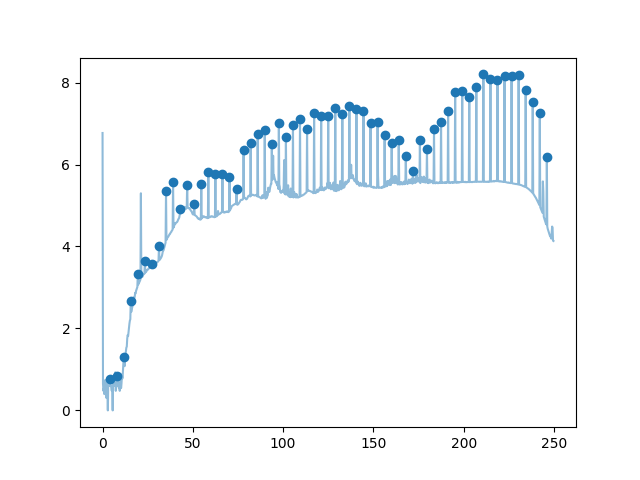

In [19]:
plt.figure()
# plt.plot(test_freq, test_spike[0])
plt.scatter(test_freq, test_spike[0])
plt.plot(freqs, np.log10(data_stack[0]), alpha=.5)
plt.show()

## Using Jax to find the beam function

Can probably get started on the base code, it will be wrong for now, but when other parts are completed, i just want to feed the resulting data into this section. im pretty sure the other parts include:
* modeling the beam of the rfsoc antenna
* measure the gain vs temperature of the rfsoc (almost done with the current data, might want more)
* use the s11 of the box antenna and the switches somehow (idk yet, for confirmation maybe)
* figure out how to deal with the missing IMU data (could probably work backwards using our times, or best case the antenna position makes the beam change in an obvious way)

I think the general process to map the beam, would be:
* ~~extract the delta functions and their frequencies~~
* The antenna beam will be coupled with the rfsoc beam (and PAM bandpass?) so will have to get rid of it
* Find the function that the spikes follow for every position, leads to $$B(\theta, \phi, \nu)$$
  - gradient descent?
  - optax?
  - just one position for now, eventually a whole sweep
  - is it different from earlier sims? before it was 1 freq with all pos, now its 1 pos with all freq?
* Once all pos and freq are known, we map?

In [15]:
import jax
import jax.numpy as jnp
from tqdm.notebook import trange
# import healpy as hp
# from functools import partial
# from healpy import get_nside, projview

In [16]:
fake_theta = 0
fake_phi = 0
coord = jnp.array([fake_theta, fake_phi])
test_freq = jnp.array(test_freq)
test_spike = jnp.array(test_spike)





In [30]:
def model(params, x):
    # params is array of shape (D+1,) for coefficients [a0, a1, …, aD]
    # f(x) = a0 + a1 x + a2 x^2 + … 
    # jnp.vdot does sum(params * [1, x, x^2…])
    powers = jnp.vander(x, N=params.shape[0], increasing=True)
    return powers @ params

# 3. Loss: mean squared error
def loss_fn(params, x, y):
    preds = model(params, x)
    return jnp.mean((preds - y)**2)

# 4. Gradient of loss wrt params
grad_loss = jax.grad(loss_fn)

# 5. Training loop
@jax.jit
def step(params, x, y, lr=1e-2):
    grads = grad_loss(params, x, y)
    return params - lr * grads

# Initialize parameters (e.g. zeros)
D = len(test_freq)
# params = jnp.zeros(D+1)
params = test_spike[0]

# Run gradient descent
for i in range(1000):
    params = step(params, test_freq, test_spike[0], lr=10)

print("Fitted coefficients:", params)

Fitted coefficients: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
